# Portfolio Optimisation

In this notebook we will perform portfolio optimisation using Monte Carlo simulation and through minimisation using scipy.minimize with different types of solver.

Large part of this code is based on the notebook 02-MPT-Portfolio-Optimization.ipynb from the course ‘Python for Finance and Algorithmic Trading with QuantConnect’ available on Udemy

In [1]:
#We import necessary libraries
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In this exercise we will only do portfolio optimisation for the energy market, so we will need to collect data on various energy-related stocks, indices and commodities:

-    XOM (ExxonMobil)
-    CVX (Chevron)
-    BP (BP plc)
-    SHEL (Shell)
-    TTE (TotalEnergies)
-    NEE (NextEra Energy)
-    DUK (Duke Energy)
-    ENPH (Enphase Energy)
-    FSLR (First Solar)
-    ^GSPE (S&P Global Clean Energy Index)
-    ICLN (iShares Global Clean Energy ETF)
-    CL=F (Crude Oil Futures)
-    NG=F (Natural Gas Futures)
-    HO=F (Heating Oil Futures)
-    RB=F (RBOB Gasoline Futures)
-    TAN (Invesco Solar ETF)
-    FAN (First Trust Global Wind Energy ETF)
-    PBW (Invesco WilderHill Clean Energy ETF)
-    QCLN (First Trust NASDAQ Clean Edge Green Energy Index Fund)


In [2]:
#We downloaded the data using yahoo finance
start_date = dt.datetime(2020, 1, 1)
end_date = dt.datetime.now()

def get_data(ticker):
    return pd.DataFrame(yf.download(ticker, start=start_date, end=end_date))['Adj Close']

# Energy Stocks
energy_stocks = ['ENPH', 'FSLR', 'SHEL','XOM', 'CVX','BP', 'TTE', 'NEE', 'DUK', ] #
stock_data = {stock: get_data(stock) for stock in energy_stocks}

# Energy Indices
energy_indices = ['^GSPE', 'ICLN']
index_data = {index: get_data(index) for index in energy_indices}

# Energy Commodities
commodities = ['CL=F','HO=F', 'RB=F', 'NG=F' ]#
commodity_data = {commodity: get_data(commodity) for commodity in commodities}

# Clean Energy ETFs
clean_energy_etfs = ['TAN', 'FAN', 'PBW', 'QCLN'] #
etf_data = {etf: get_data(etf) for etf in clean_energy_etfs}


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [3]:
#Convert the data in a pandas DataFrame
stock_data = pd.DataFrame.from_dict(stock_data)
index_data = pd.DataFrame.from_dict(index_data)
commodity_data = pd.DataFrame.from_dict(commodity_data)
etf_data = pd.DataFrame.from_dict(etf_data)

#We concatenate the data
df_portf = pd.concat([stock_data,index_data, commodity_data, etf_data], axis=1)
print('shape df_portf', df_portf.shape)
print('nan per column: ',df_portf.isna().sum())

#remove nan
df_portf.dropna(inplace=True)
print('shape final df_portf', df_portf.shape)


shape df_portf (1199, 19)
nan per column:  ENPH     1
FSLR     1
SHEL     1
XOM      1
CVX      1
BP       1
TTE      1
NEE      1
DUK      1
^GSPE    1
ICLN     1
CL=F     1
HO=F     0
RB=F     0
NG=F     0
TAN      1
FAN      1
PBW      1
QCLN     1
dtype: int64
shape final df_portf (1198, 19)


<Axes: xlabel='Date'>

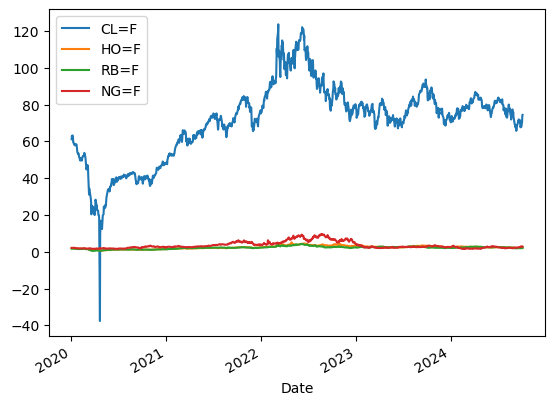

In [4]:
#We can plot the data
commodity_data.plot() 

### Daily returns
Let's get the daily returns for each data. We can plot all the data together, but due to the dimensionality of the different variables it is better if we plot by category:  **energy_stocks**, **energy_indices**, **commodities** or **clean_energy_etfs**

<Axes: title={'center': 'energy_indices'}, xlabel='Date'>

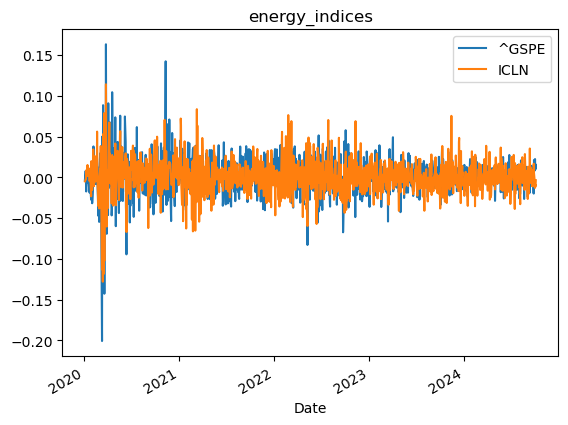

In [5]:
df_portf_returns = df_portf.pct_change(1).dropna()
df_portf_returns[energy_indices].plot(label='energy_indices', title='energy_indices')


<Axes: title={'center': 'energy_stocks'}, xlabel='Date'>

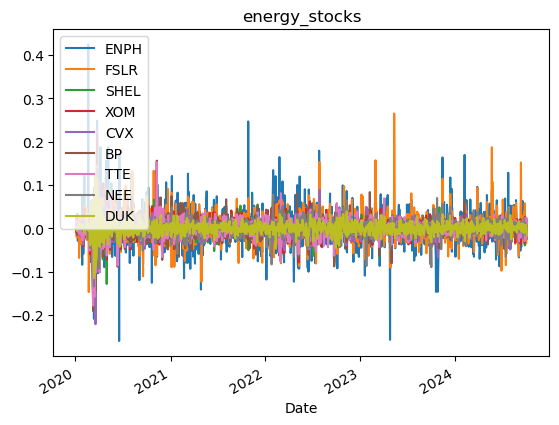

In [6]:
df_portf_returns[energy_stocks].plot(label='energy_stocks', title='energy_stocks')


# Cummulative Return
Next we will calculate the return for an ETF and compare it to the return if we had invested in all of our options equally.

Text(0, 0.5, 'Cumulative Return %')

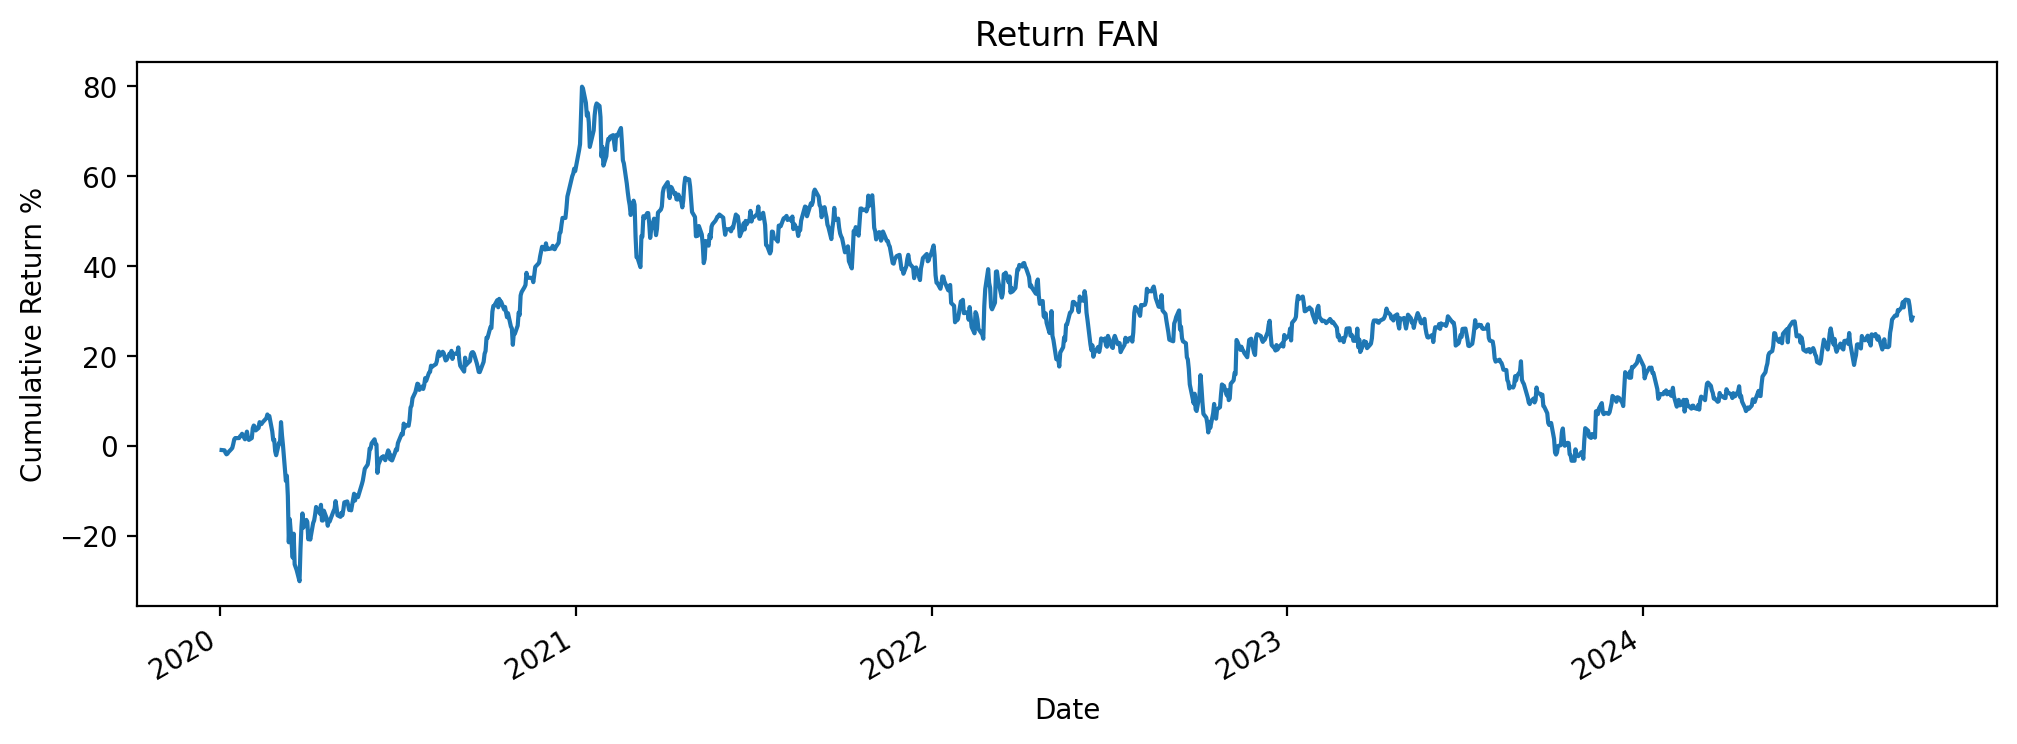

In [7]:
#Cummulative return for FAN
cumul_return_etf = (1 + df_portf_returns['FAN']).cumprod() - 1
cumul_return_etf = cumul_return_etf*100
plt.figure(dpi=200)

cumul_return_etf.plot(label='FAN', title='Return FAN', figsize=(12,4)) 
plt.ylabel("Cumulative Return %")


In [8]:
# Equal weight
N = len(df_portf_returns.columns)
equal_weights = np.ones(N)/N
equal_weights


array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.05263158, 0.05263158, 0.05263158, 0.05263158])

In [9]:
equal_returns = np.dot(equal_weights, df_portf_returns.transpose())
equal_returns


array([ 0.00389882,  0.0031754 , -0.00168304, ...,  0.00102944,
        0.00810304,  0.00177146])

In [10]:
cum_equal_returns =   (1 + equal_returns).cumprod() - 1
cum_equal_returns

array([0.00389882, 0.0070866 , 0.00539163, ..., 0.61329057, 0.62636314,
       0.62924417])

In [11]:
cum_equal_returns_perc = 100 * pd.Series(cum_equal_returns)
cum_equal_returns_perc.index = df_portf_returns.index
cum_equal_returns_perc

Date
2020-01-03     0.389882
2020-01-06     0.708660
2020-01-07     0.539163
2020-01-08    -0.233723
2020-01-09     0.183637
                ...    
2024-09-30    60.840986
2024-10-01    61.163150
2024-10-02    61.329057
2024-10-03    62.636314
2024-10-04    62.924417
Length: 1197, dtype: float64

Now we will compare whether equal weighted or all in FAN is better.

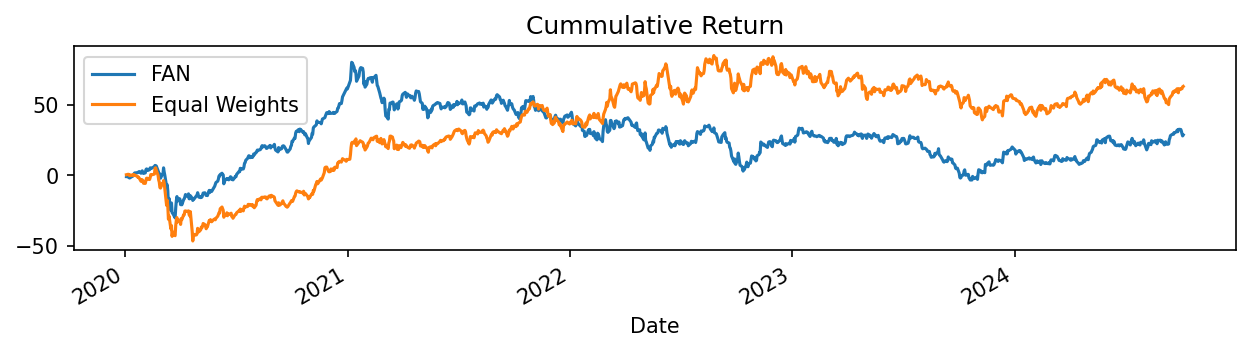

In [12]:
plt.figure(dpi=150)
cumul_return_etf.plot(figsize=(10,2),label='FAN', title='Cummulative Return')
cum_equal_returns_perc.plot(figsize=(10,2),label='Equal Weights')
plt.legend()

# Monte Carlo for Portfolio Optimisation

To find a better distribution of the weights of portfolio we will use Monte Carlo, which consists of randomly searching for the optimal weights, so it is necessary to do many simulations.

A good practice is to use logarithmic returns, which offer mathematical and statistical advantages that make them especially useful for financial modelling, portfolio optimisation, as well as being widely used in Machine Learning. They offer a more accurate representation of compound growth and are better suited to the statistical assumptions underlying many financial models.

In [13]:
df_portf_log = np.log(df_portf/df_portf.shift(1))
df_portf_log_cov = df_portf_log.cov()


/home/mam123/anaconda3/envs/QML_env/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [14]:
#We define a function for portfolio returns
def calculate_returns(weights,log_rets):
    return np.sum(log_rets.mean()*weights) * 252 #252 is the number of trading days per year

#portfolio volatility/ variance 
def calculate_volatility(weights, log_rets_cov):
    annualized_cov = np.dot(log_rets_cov*252, weights)
    vol = np.dot(weights.transpose(), annualized_cov)
    return np.sqrt(vol)

def generate_weights(N):
    weights = np.random.random(N)
    return weights/ np.sum(weights)

We now perform many iterations to find appropriate weights. We plot the expected returns against the expected volatility and colour them by the Sharpe ratio.

In [15]:
mc_portfolio_returns = []
mc_portfolio_vol = []
mc_weights = []
for sim in range(10000000):
    weights = generate_weights(N=df_portf_log.shape[1])
    mc_weights.append(weights)
    mc_portfolio_returns.append(calculate_returns(weights,df_portf_log))
    mc_portfolio_vol.append(calculate_volatility(weights,df_portf_log_cov))

In [16]:
mc_sharpe_ratios = np.array(mc_portfolio_returns)/np.array(mc_portfolio_vol)

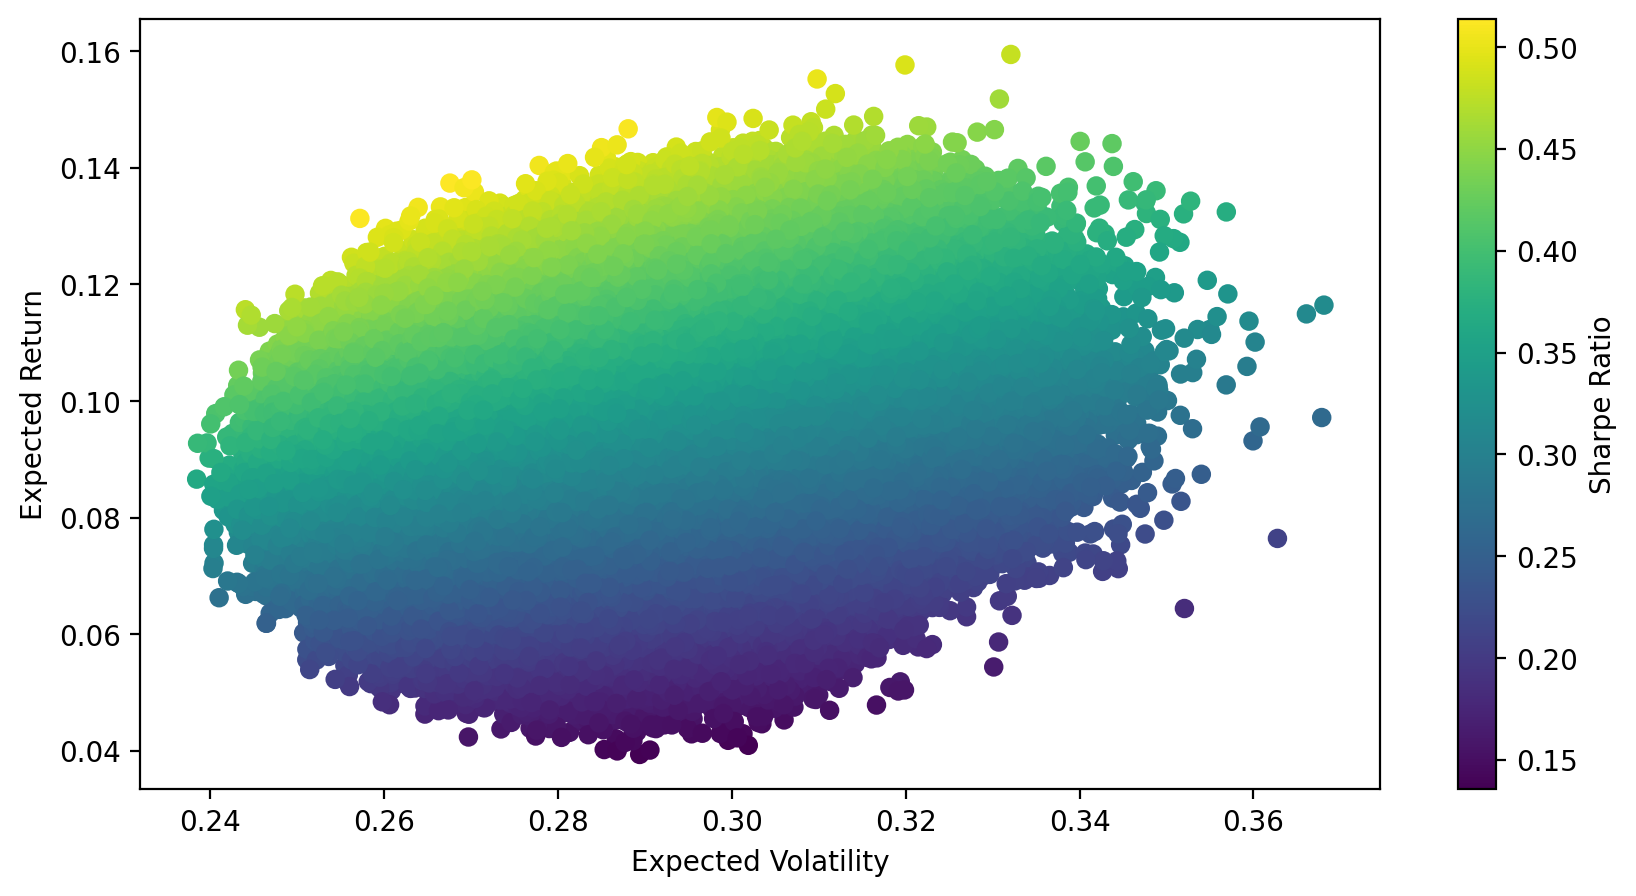

In [17]:
plt.figure(dpi=200,figsize=(10,5))
plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.ylabel('Expected Return')
plt.xlabel('Expected Volatility')
plt.colorbar(label="Sharpe Ratio");

In [18]:
mc_weights[np.argmax(mc_sharpe_ratios)] #Optimal founded

array([0.05888037, 0.11985538, 0.02929648, 0.10158699, 0.03399473,
       0.01446067, 0.10291272, 0.10884732, 0.10581827, 0.06594936,
       0.01541149, 0.11596272, 0.01820246, 0.02769512, 0.03628937,
       0.0100848 , 0.017252  , 0.00295422, 0.01454553])

# Optimal Weighting through Minimization Search

Using the Sharpe ratio as the target function, we will search for an optimum using the scipy.minimize solvers.

In [19]:
from scipy.optimize import minimize

In [20]:
def function_to_minimize(weights):
    # Note -1* because we need to minimize this
    # Its the same as maximizing the positive sharpe ratio
    return -1 * (calculate_returns(weights,df_portf_log)/calculate_volatility(weights,df_portf_log_cov))

In [21]:
N = len(df_portf_log.columns)

bounds = tuple((0,1) for n in range(N))
w = np.random.random(N)
w = w/w.sum()

# Need to constrain all weights to add up to 1
sum_constraint = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1})

In [22]:
result = minimize(fun=function_to_minimize,x0=w,bounds=bounds,constraints=sum_constraint)
opt_weights = result.x

In [23]:
opt_returns = np.dot(opt_weights, df_portf_returns.transpose())
cum_opt_returns =   (1 + opt_returns).cumprod() - 1
cum_opt_returns_perc = 100 * pd.Series(cum_opt_returns)
cum_opt_returns_perc.index = df_portf_returns.index


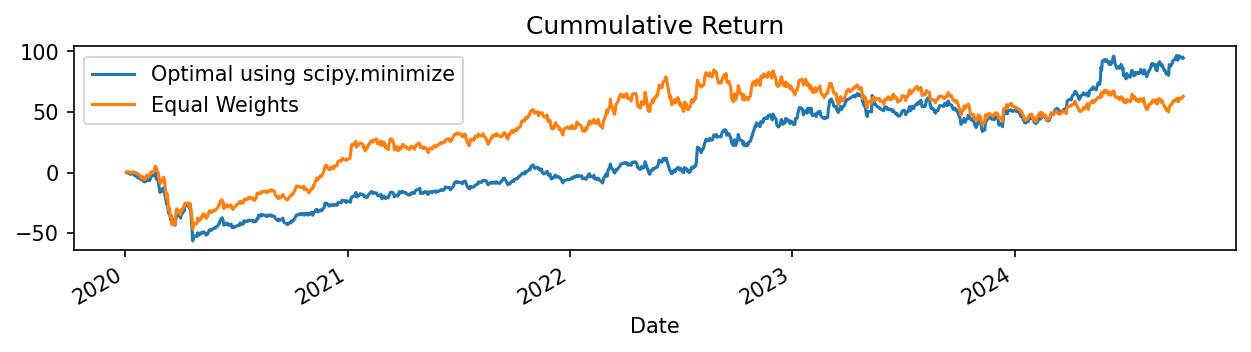

In [24]:
plt.figure(dpi=150)
cum_opt_returns_perc.plot(figsize=(10,2),label='Optimal using scipy.minimize', title='Cummulative Return')
cum_equal_returns_perc.plot(figsize=(10,2),label='Equal Weights')
plt.legend()
plt.show()

## Efficient Frontier
The efficient frontier is the optimal set of portfolios that offer the highest expected return for a given level of risk. To do this we must include new restrictions to our optimisation algorithm, where we will penalise and/or consider sub-optimal the soutions that are outside the required risk level.


In [25]:
expected_returns_range = np.linspace(0.04,0.12,100)


In [26]:
frontier_volatility = []

for possible_return in expected_returns_range:

    constraints = ({'type':'eq','fun': lambda weights: np.sum(weights)-1},
               {'type':'eq','fun': lambda weights: calculate_returns(weights,df_portf_log) - possible_return})
    
    result = minimize(lambda weights: calculate_volatility(weights,df_portf_log_cov), w, bounds=bounds,constraints=constraints)
    
    frontier_volatility.append(result['fun'])

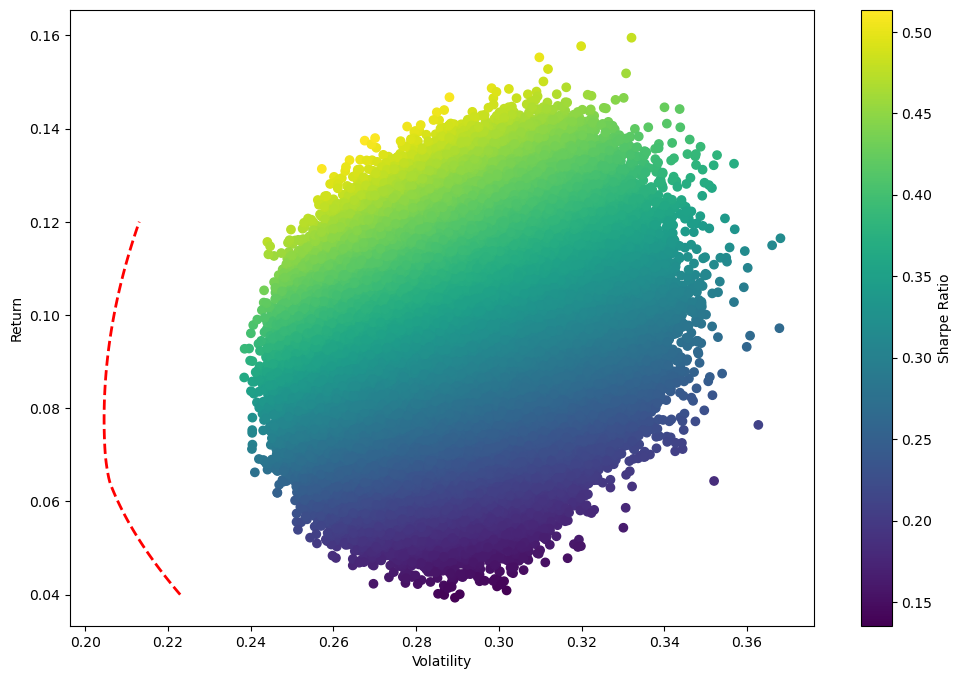

In [27]:
plt.figure(figsize=(12,8))
plt.scatter(mc_portfolio_vol,mc_portfolio_returns,c=mc_sharpe_ratios)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add frontier line
plt.plot(frontier_volatility,expected_returns_range,'r--',linewidth=2)
plt.show()

From this we can visualise that not enough Monte Carlo simulations are being performed, so the full range of possible portfolios is not being captured. A larger number of simulations can be done, however, it is computationally expensive, particularly if one only has a laptop with low performance